### Загружаем данные для обучения: `train_texts`, `val_texts`, `test_texts`

In [1]:
from datasets import load_dataset

from sklearn.model_selection import train_test_split

from os.path import isfile

from src.data_utils import clean_text

import pandas as pd

import numpy as np

import os


train_texts, val_texts, test_texts = None, None, None
foldername = 'data'
raw_dataset_filepath = os.path.join(foldername, 'raw_dataset.csv')
processed_dataset_filepath = os.path.join(foldername, 'processed_dataset.csv')
train_filepath = os.path.join(foldername, 'train.csv')
val_filepath = os.path.join(foldername, 'val.csv')
test_filepath = os.path.join(foldername, 'test.csv')
text_column = 'text'

# Если такие файлы уже есть, загружаем данные для обучения из них
if isfile(train_filepath) and isfile(val_filepath) and isfile(test_filepath):
    train_texts = pd.read_csv(train_filepath).dropna()[text_column].to_list()
    val_texts = pd.read_csv(val_filepath).dropna()[text_column].to_list()
    test_texts = pd.read_csv(test_filepath).dropna()[text_column].to_list()
# В противном случае скачиваем датасет, обрабатываем, делим его на выборки и сохраняем
else:
    dataset = load_dataset('sentiment140', trust_remote_code=True, split='train', cache_dir='data')['text']
    dataset_df = pd.DataFrame({ text_column: dataset })
    dataset_df.to_csv(raw_dataset_filepath, index=False)

    texts = list(map(clean_text, dataset))
    print(len(texts))
    texts_df = pd.DataFrame({ text_column: texts })
    texts_df.to_csv(processed_dataset_filepath, index=False)

    val_test = 0.2
    test = 0.5
    train_texts, val_test_texts = train_test_split(texts, test_size=val_test, random_state=42)
    val_texts, test_texts = train_test_split(val_test_texts, test_size=test)

    train_df = pd.DataFrame({ text_column: train_texts })
    train_df.to_csv(train_filepath, index=False)

    test_df = pd.DataFrame({ text_column: test_texts })
    test_df.to_csv(test_filepath, index=False)

    val_df = pd.DataFrame({ text_column: val_texts })
    val_df.to_csv(val_filepath, index=False)

/home/ubuntu/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating test split: 100%|██████████| 498/498 [00:00<00:00, 25995.16 examples/s]


1600000


### Из полученных данных формируем датасеты

Я использовала посимвольную токенизацию, так как она, на мой взгляд, лучше подходит для LSTM автодополнений, чем разбиение на подслова, как в bert-base-uncased.

In [2]:
from torch.utils.data import DataLoader

from src.next_token_dataset import NextTokenDataset, EvalROUGEDataset, collate_fn, collate_fn_rouge_ds
from src.char_tokenizer import CharTokenizer


tokenizer = CharTokenizer()

batch_size = 256

sorted_ids = np.argsort([len(text) for text in train_texts])
train_texts = np.array(train_texts)[sorted_ids]
train_dataset = NextTokenDataset(train_texts, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

sorted_ids = np.argsort([len(text) for text in val_texts])
val_texts = np.array(val_texts)[sorted_ids]
val_dataset = NextTokenDataset(val_texts, tokenizer)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)

# Датасет для вычисления метрик ROUGE на валидационных данных
val_rouge_dataset = EvalROUGEDataset(val_texts, tokenizer)
val_rouge_dataloader = DataLoader(val_rouge_dataset, batch_size=batch_size, collate_fn=collate_fn_rouge_ds)

sorted_ids = np.argsort([len(text) for text in test_texts])
test_texts = np.array(test_texts)[sorted_ids]
test_dataset = EvalROUGEDataset(test_texts, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn_rouge_ds)

### Обучаем модель:

In [3]:
from src.lstm_model import LSTMAutoComplete
from src.model_train import train_one_epoch
from src.model_eval import evaluate_model

from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt

import torch.nn as nn
import torch

import os


device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Определяем модель:
## 2 скрытых слоя
## размерность скрытого состояния 512
model = LSTMAutoComplete(len(tokenizer.vocab), pad_token_id=tokenizer.pad_token_id, hidden_size=512, num_layers=2)
model

LSTMAutoComplete(
  (embedding): Embedding(51, 512, padding_idx=0)
  (lstm): LSTM(512, 512, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (ffn): Linear(in_features=512, out_features=51, bias=True)
)

=== Before training ===


Evaluating ROUGE: 100%|██████████| 368/368 [08:35<00:00,  1.40s/it]


Validation loss: 3.9316408128842064
Rouge metrics:
rouge1: 0.0035
rouge2: 0.0000
rougeL: 0.0035
rougeLsum: 0.0035
what are you talking vl).0tr ?2q 60:1v;ee!s



Training epoch 1: 100%|██████████| 2928/2928 [13:37<00:00,  3.58it/s]


Epoch: 1, training loss: 1.5398


Evaluating ROUGE: 100%|██████████| 368/368 [08:40<00:00,  1.41s/it]


Validation loss: 1.3412280173405358
Rouge metrics:
rouge1: 0.0744
rouge2: 0.0049
rougeL: 0.0742
rougeLsum: 0.0742
what are you talking  again? jt he's so gd. hay against girly



Training epoch 2: 100%|██████████| 2928/2928 [13:39<00:00,  3.57it/s]


Epoch: 2, training loss: 1.3404


Evaluating ROUGE: 100%|██████████| 368/368 [08:41<00:00,  1.42s/it]


Validation loss: 1.297888966034288
Rouge metrics:
rouge1: 0.0801
rouge2: 0.0063
rougeL: 0.0799
rougeLsum: 0.0798
what are you talking  me lately this is back later and i thou



Training epoch 3: 100%|██████████| 2928/2928 [13:38<00:00,  3.58it/s]


Epoch: 3, training loss: 1.3070


Evaluating ROUGE: 100%|██████████| 368/368 [08:34<00:00,  1.40s/it]


Validation loss: 1.2769372942654982
Rouge metrics:
rouge1: 0.0819
rouge2: 0.0067
rougeL: 0.0817
rougeLsum: 0.0817
what are you talking  about spamburg (bridesman, pending hel



Training epoch 4: 100%|██████████| 2928/2928 [13:40<00:00,  3.57it/s]


Epoch: 4, training loss: 1.2778


Evaluating ROUGE: 100%|██████████| 368/368 [08:43<00:00,  1.42s/it]


Validation loss: 1.258436546701452
Rouge metrics:
rouge1: 0.0843
rouge2: 0.0072
rougeL: 0.0841
rougeLsum: 0.0841
what are you talking  about with chuockrowin's tweet talk rea



Training epoch 5: 100%|██████████| 2928/2928 [13:38<00:00,  3.58it/s]


Epoch: 5, training loss: 1.2684


Evaluating ROUGE: 100%|██████████| 368/368 [08:45<00:00,  1.43s/it]


Validation loss: 1.2530170183466829
Rouge metrics:
rouge1: 0.0847
rouge2: 0.0073
rougeL: 0.0845
rougeLsum: 0.0844
what are you talking  about? me, singer and - thanks darn, i 



Training epoch 6: 100%|██████████| 2928/2928 [13:40<00:00,  3.57it/s]


Epoch: 6, training loss: 1.2617


Evaluating ROUGE: 100%|██████████| 368/368 [08:39<00:00,  1.41s/it]


Validation loss: 1.2488983999127927
Rouge metrics:
rouge1: 0.0861
rouge2: 0.0078
rougeL: 0.0859
rougeLsum: 0.0859
what are you talking ? assholes needs resist harry, duck crac



Training epoch 7: 100%|██████████| 2928/2928 [13:40<00:00,  3.57it/s]


Epoch: 7, training loss: 1.2488


Evaluating ROUGE: 100%|██████████| 368/368 [08:42<00:00,  1.42s/it]


Validation loss: 1.2413681994961656
Rouge metrics:
rouge1: 0.0862
rouge2: 0.0077
rougeL: 0.0860
rougeLsum: 0.0860
what are you talking  about? such a lovely day.



Training epoch 8: 100%|██████████| 2928/2928 [13:40<00:00,  3.57it/s]


Epoch: 8, training loss: 1.2450


Evaluating ROUGE: 100%|██████████| 368/368 [08:48<00:00,  1.44s/it]


Validation loss: 1.2391210619522177
Rouge metrics:
rouge1: 0.0885
rouge2: 0.0084
rougeL: 0.0882
rougeLsum: 0.0882
what are you talking  about? i know summer angle is geing a b



Training epoch 9: 100%|██████████| 2928/2928 [13:39<00:00,  3.57it/s]


Epoch: 9, training loss: 1.2423


Evaluating ROUGE: 100%|██████████| 368/368 [08:45<00:00,  1.43s/it]


Validation loss: 1.237497992489649
Rouge metrics:
rouge1: 0.0882
rouge2: 0.0085
rougeL: 0.0880
rougeLsum: 0.0880
what are you talking  about? i do see stickams like miley wit



Training epoch 10: 100%|██████████| 2928/2928 [13:40<00:00,  3.57it/s]


Epoch: 10, training loss: 1.2356


Evaluating ROUGE: 100%|██████████| 368/368 [08:49<00:00,  1.44s/it]


Validation loss: 1.2340524410424025
Rouge metrics:
rouge1: 0.0883
rouge2: 0.0085
rougeL: 0.0881
rougeLsum: 0.0880
what are you talking  about? i have 3 kids and go say hi



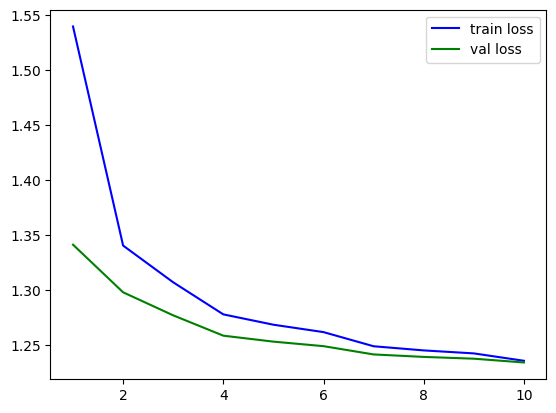

In [5]:

optimizer = Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, 3, 0.5)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
epochs = 10
last_epoch = epochs
test_phrase = "what are you talking"

# Посмотрим на валидационные метрики до обучения:
print('=== Before training ===')
evaluate_model(model, tokenizer, device, val_dataloader, val_rouge_dataloader, criterion, test_phrase=test_phrase)
print('===================================\n')

train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 3
patience_counter = 0

# Сюда будет сохраняться лучшая модель
folder = 'checkpoints'
os.makedirs(folder, exist_ok=True)
PATH = os.path.join(folder, 'best_model.pth')
PATH_INTER = os.path.join(folder, 'intermediate_model.pth')

# Обучаем модель в течение 20-ти эпох
for epoch in range(1, epochs+1):
    train_loss = train_one_epoch(model, device, epoch, train_dataloader, optimizer, criterion, scheduler)
    val_loss = evaluate_model(model, tokenizer, device, val_dataloader, val_rouge_dataloader, criterion, test_phrase=test_phrase)
    print('===================================\n')
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    if abs(val_loss - best_val_loss) < 1e-4:
        best_val_loss = val_loss
#       Сохраним лучшую модель
        torch.save(model.state_dict(), PATH)        
        patience_counter +=1
        if patience_counter >= patience:
            print('Early stopping triggered...')
            last_epoch = epoch
            break
    else:
        patience_counter = 0
        
    torch.save(model.state_dict(), PATH_INTER)

# Сохраним результаты обучения
torch.save(model.state_dict(), PATH)
plt.plot(list(range(1, last_epoch+1)), train_losses, color='b', label='train loss')
plt.plot(list(range(1, last_epoch+1)), val_losses, color='g', label='val loss')
plt.legend()
plt.show()

In [7]:
from transformers.utils import logging

logging.set_verbosity_error()

### Теперь на тестовых данных сравним работу LSTM модели и GPT2.
Моделям было предложено примерно 3/4 исходного текста, которые нужно было дополнить 1/4. 

In [ ]:
from transformers import pipeline

# Воспользуемся пайпланом для генерации текста и загрузим модель gpt2
generator = pipeline('text-generation', model='distilgpt2', batch_size=batch_size, device=device, truncation=True)
generator.tokenizer.pad_token_id = generator.tokenizer.eos_token_id
generator.tokenizer.padding_side = 'left'

Device set to use cuda


In [8]:
from src.gpt_vs_lstm_eval import evaluate_gpt_vs_lstm

evaluate_gpt_vs_lstm(model, generator, tokenizer, test_dataloader, batch_size=batch_size, device=device)

Autocompleting inputs: 100%|██████████| 366/366 [12:06<00:00,  1.99s/it]


Rouge metrics for test (GPT2):
rouge1: 0.0393
rouge2: 0.0027
rougeL: 0.0385
rougeLsum: 0.0385
Rouge metrics for test (LSTM-based):
rouge1: 0.0887
rouge2: 0.0081
rougeL: 0.0885
rougeLsum: 0.0885
=== Samples ===
Input: "dont finish college till 4! someone "
	GPT2-autocomplete: "!!



"
	LSTM-autocomplete: "bub come germa"

Input: "happy closing i wish you all gd luck"
	GPT2-autocomplete: " and luck while you sleep"
	LSTM-autocomplete: " finding out a"

Input: "but when?? the rain gods r still on "
	GPT2-autocomplete: "!! i don't think"
	LSTM-autocomplete: "a few nights i"

Input: "md day!! haircut, lunch w dad, down "
	GPT2-autocomplete: "????!!!"
	LSTM-autocomplete: "the outside, a"

Input: "- i wish i was there. mom wouldn't b"
	GPT2-autocomplete: "t me. i was"
	LSTM-autocomplete: "e on ys once h"



У LSTM метрика ROUGE получилась выше, чем у GPT2. LSTM-модель неплохо предсказывает служебные слова, а также слова из устойчивых словосочетаний, идущие непосредственно друг за другом. Я бы рекомендовала использовать эту модель для автодополнения 2-3 следующих слов, но не для всей фразы. Кроме того, такой датасет как список твитов очень "шумный": он может содержать много опечаток и орфографических ошибок (как преднамеренных так и нет), что затрудняет процесс обучения.